In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

datapath = "Data"
figurepath = "Figures"

In [2]:
df = pd.read_csv(os.path.join(datapath, "data.csv"))
df = df[df["Study design"] != "Non random"]
df = df[df["Study design"] != "Follow up"]
df["Seroprotection"] = df["Seroprotection no. (%)"].str.replace(r"\(.*\)","")
df = df[df["Weight group"] != "Underweight"]

weightGroup = ["Normal", "Non-obese", "Overweight", "Overweight/obese", "Obese", "Morbid obese"]
df["Weight group"] = pd.Categorical(df["Weight group"], weightGroup)
# ageGroup = ["Children", "Teenagers", "Adults", "Military Adults", "Healthcare workers", "Elder"]

In [3]:
AE = df[[
    "Study Author, Year",
    "Weight group",
    "Ethnic",
    "Subject",
    "Vaccine type",
    "Sample size",
    "Male no.",
    "System adverse no."
]]
AE = AE[AE["System adverse no."].notna()].sort_values("Weight group")
AE["System adverse no."] = AE["System adverse no."].astype(int)
AE["System adverse rate"] = AE["System adverse no."] / AE["Sample size"]
AE = AE.round({"System adverse rate": 2})
AE["System adverse no. (%)"] = AE["System adverse no."].astype(str) + " (" + AE["System adverse rate"].astype(str) + ")"
AE.to_csv(os.path.join(datapath, "AE.csv"), sep=",", index=False)

In [4]:
SP = df[[
    "Study Author, Year",
    "Weight group",
    "Ethnic",
    "Subject",
    "Vaccine type",
    "Vaccine strain",
    "Seroprotection no. (%)"
]]
SP = SP[SP["Seroprotection no. (%)"].notna()].sort_values("Weight group")
SP.to_csv(os.path.join(datapath, "SP.csv"), sep=",", index=False)

In [5]:
ageColor = {
    "Adults": "#1E90FF",
    "Healthcare workers": "#191970",
    "Military Adults": "#0000FF",
    "Teenagers": "#87CEFA",
    "Children": "#008000",
    "Elder": "#FF0000"
}

In [6]:
# Extract the H1N1 portion of data for trivalent vaccine so to be compared with H1N1 monovalent vaccine
h1n1 = df[(df["Vaccine strain"] == "H1N1") | (df["Vaccine strain"] == "trivalent")]

In [7]:
weightVSprotect = h1n1[["Subject", "Weight group", "Sample size", "Seroprotection"]].dropna()
weightVSprotect["Seroprotection"] = weightVSprotect["Seroprotection"].astype(int)
weightVSprotect = weightVSprotect.groupby(["Subject", "Weight group"])
weightVSprotect = weightVSprotect.agg({"Sample size": "sum", "Seroprotection": "sum"}).reset_index()

weightVSadverse = h1n1[["Subject", "Weight group", "Sample size", "System adverse no."]].dropna()
weightVSadverse["System adverse no."] = weightVSadverse["System adverse no."].astype(int)
weightVSadverse = weightVSadverse.groupby(["Subject", "Weight group"])
weightVSadverse = weightVSadverse.agg({"Sample size": "sum", "System adverse no.": "sum"}).reset_index()

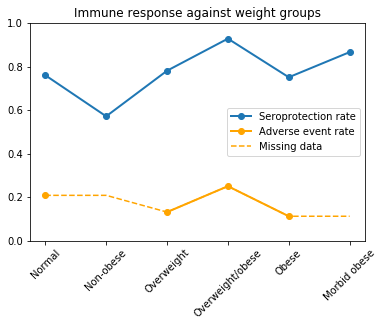

In [8]:
groupByWeight = weightVSprotect.groupby("Weight group").agg({"Sample size": "sum", "Seroprotection": "sum"})
groupByWeight["Seroprotection rate"] = groupByWeight["Seroprotection"] / groupByWeight["Sample size"]
groupByWeight = groupByWeight.reindex(weightGroup)

x_pos = np.arange(len(groupByWeight))

plt.plot(x_pos, groupByWeight["Seroprotection rate"], "-o", lw=2, label = "Seroprotection rate")

groupByWeight = weightVSadverse.groupby("Weight group").agg({"Sample size": "sum", "System adverse no.": "sum"})
groupByWeight["AE rate"] = groupByWeight["System adverse no."] / groupByWeight["Sample size"]
groupByWeight = groupByWeight.reindex(["Normal", "Non-obese", "Overweight", "Overweight/obese", "Obese", "Morbid obese"])

plt.plot(x_pos, groupByWeight["AE rate"], "-o", color="orange", lw=2, label="Adverse event rate")
plt.plot(x_pos, groupByWeight["AE rate"].fillna(method="ffill"), "--", color="orange", label="Missing data")

plt.xticks(x_pos, groupByWeight.index.values, rotation=45)
plt.ylim(0,1)
plt.legend()
plt.title("Immune response against weight groups")
plt.savefig(os.path.join(figurepath, "comparison.pdf"), bbox_inches="tight")
plt.show()

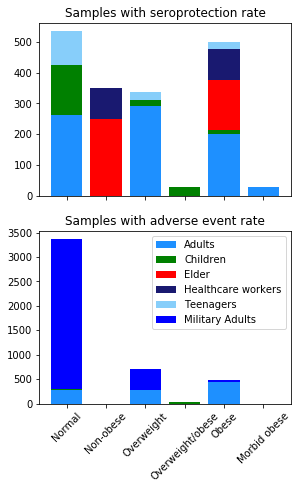

In [9]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize = (4.5, 7))
x_pos = np.arange(len(weightGroup))

bottom = np.zeros(len(weightGroup))
for i in weightVSprotect["Subject"].unique():
    subgroup = weightVSprotect[weightVSprotect["Subject"] == i]
    subgroup = subgroup.set_index("Weight group").fillna(0)
    axes[0].bar(
        x_pos,
        subgroup["Sample size"],
        label=i,
        color=ageColor[i],
        bottom=bottom
    )
    bottom += subgroup["Sample size"]
axes[0].set_title("Samples with seroprotection rate")

bottom = np.zeros(len(weightGroup))
axes[1].bar(x_pos, bottom)
for i in weightVSadverse["Subject"].unique():
    subgroup = weightVSadverse[weightVSadverse["Subject"] == i]
    subgroup = subgroup.set_index("Weight group").fillna(0)
    axes[1].bar(
        x_pos,
        subgroup["Sample size"],
        label=i,
        color=ageColor[i],
        bottom=bottom
    )
    bottom += subgroup["Sample size"]
axes[1].set_title("Samples with adverse event rate")

handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)

plt.xticks(x_pos, weightGroup, rotation=45)
plt.legend(handles, labels, loc='upper right')
plt.savefig(os.path.join(figurepath, "age.pdf"), bbox_inches="tight")
plt.show()

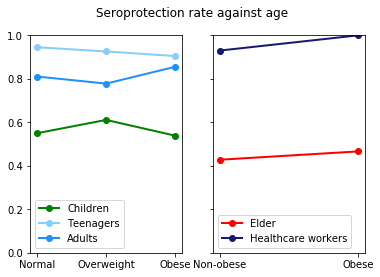

In [10]:
fig, axes = plt.subplots(1, 2, sharey=True)
fig.suptitle("Seroprotection rate against age")

weightAgeVSprotect = weightVSprotect[
    (weightVSprotect["Weight group"] == "Normal") |
    (weightVSprotect["Weight group"] == "Overweight") |
    (weightVSprotect["Weight group"] == "Obese")
]

x_pos = np.arange(3)
for i in ("Children", "Teenagers", "Adults"):
    subgroup = weightAgeVSprotect[weightAgeVSprotect["Subject"] == i]
    if subgroup.empty is False:
        subgroup = subgroup.set_index("Weight group").fillna(0)
        rate = subgroup["Seroprotection"] / subgroup["Sample size"]
        axes[0].plot(x_pos, rate, "-o", lw=2, label = i, color=ageColor[i])
        
plt.sca(axes[0])
plt.xticks(x_pos, subgroup.index.values)
plt.legend()

weightAgeVSprotect = weightVSprotect[
    (weightVSprotect["Weight group"] == "Non-obese") |
    (weightVSprotect["Weight group"] == "Obese")
]

x_pos = np.arange(2)
for i in ("Elder", "Healthcare workers"):
    subgroup = weightAgeVSprotect[weightAgeVSprotect["Subject"] == i]
    if subgroup.empty is False:
        subgroup = subgroup.set_index("Weight group").fillna(0)
        rate = subgroup["Seroprotection"] / subgroup["Sample size"]
        axes[1].plot(x_pos, rate, "-o", lw=2, label = i, color=ageColor[i])

plt.sca(axes[1])
plt.xticks(x_pos, subgroup.index.values)
plt.legend()
plt.ylim(0,1)
plt.savefig(os.path.join(figurepath, "ageComparison.pdf"), bbox_inches="tight")
plt.show()

In [11]:
# fig, axes = plt.subplots(1, 2, sharey=True)
# fig.suptitle("Adverse event rate against age and valence")

# weightVSadverse = h1n1[["Subject", "Weight group", "Sample size", "System adverse no."]].dropna()
# weightVSadverse["System adverse no."] = weightVSadverse["System adverse no."].astype(int)
# weightVSadverse = weightVSadverse.groupby(["Subject", "Weight group"])
# weightVSadverse = weightVSadverse.agg({"Sample size": "sum", "System adverse no.": "sum"}).reset_index()
# weightAgeVSadverse = weightVSadverse[
#     (weightVSadverse["Weight group"] == "Normal") |
#     (weightVSadverse["Weight group"] == "Overweight") |
#     (weightVSadverse["Weight group"] == "Obese")
# ]

# x_pos = np.arange(3)
# for i in ("Adults", "Military Adults"):
#     subgroup = weightAgeVSadverse[weightAgeVSadverse["Subject"] == i]
#     if subgroup.empty is False:
#         subgroup = subgroup.set_index("Weight group").fillna(0)
#         rate = subgroup["System adverse no."] / subgroup["Sample size"]
#         axes[0].plot(x_pos, rate, "-o", lw=2, label = i, color=ageColor[i])
        
# plt.sca(axes[0])
# plt.xticks(x_pos, subgroup.index.values)
# plt.legend()

# weightValenceVSadverse = h1n1[["Vaccine type", "Weight group", "Sample size", "System adverse no."]].dropna()
# weightValenceVSadverse["System adverse no."] = weightValenceVSadverse["System adverse no."].astype(int)
# weightValenceVSadverse = weightValenceVSadverse.groupby(["Vaccine type", "Weight group"])
# weightValenceVSadverse = weightValenceVSadverse.agg({"Sample size": "sum", "System adverse no.": "sum"}).reset_index()

# weightValenceVSadverse = weightValenceVSadverse[
#     (weightValenceVSadverse["Weight group"] == "Normal") |
#     (weightValenceVSadverse["Weight group"] == "Overweight") |
#     (weightValenceVSadverse["Weight group"] == "Obese")
# ]

# x_pos = np.arange(3)
# for i in ("Monovalent", "Trivalent"):
#     subgroup = weightValenceVSadverse[weightValenceVSadverse["Vaccine type"] == i]
#     if subgroup.empty is False:
#         subgroup = subgroup.set_index("Weight group").fillna(0)
#         rate = subgroup["System adverse no."] / subgroup["Sample size"]
#         axes[1].plot(x_pos, rate, "-o", lw=2, label = i, color=valentColor[i])

# plt.sca(axes[1])
# plt.xticks(x_pos, subgroup.index.values)
# plt.legend()
# plt.ylim(0,1)
# plt.savefig(os.path.join(figurepath, "adverseEvent.pdf"), bbox_inches="tight")
# plt.show()

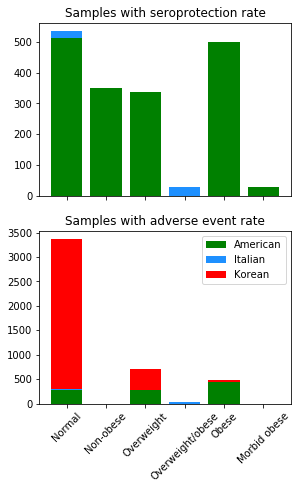

In [12]:
ethnicColor = {"American": "#008000", "Korean": "#FF0000", "Italian": "#1E90FF"}

weightVSprotect = h1n1[["Ethnic", "Weight group", "Sample size", "Seroprotection"]].dropna()
weightVSprotect["Seroprotection"] = weightVSprotect["Seroprotection"].astype(int)
weightVSprotect = weightVSprotect.groupby(["Ethnic", "Weight group"])
weightVSprotect = weightVSprotect.agg({"Sample size": "sum", "Seroprotection": "sum"}).reset_index()

weightVSadverse = h1n1[["Ethnic", "Weight group", "Sample size", "System adverse no."]].dropna()
weightVSadverse["System adverse no."] = weightVSadverse["System adverse no."].astype(int)
weightVSadverse = weightVSadverse.groupby(["Ethnic", "Weight group"])
weightVSadverse = weightVSadverse.agg({"Sample size": "sum", "System adverse no.": "sum"}).reset_index()

fig, axes = plt.subplots(2, 1, sharex=True, figsize = (4.5, 7))
x_pos = np.arange(len(weightGroup))

bottom = np.zeros(len(weightGroup))
for i in weightVSprotect["Ethnic"].unique():
    subgroup = weightVSprotect[weightVSprotect["Ethnic"] == i]
    subgroup = subgroup.set_index("Weight group").fillna(0)
    axes[0].bar(
        x_pos,
        subgroup["Sample size"],
        label=i,
        color=ethnicColor[i],
        bottom=bottom
    )
    bottom += subgroup["Sample size"]
axes[0].set_title("Samples with seroprotection rate")

bottom = np.zeros(len(weightGroup))
axes[1].bar(x_pos, bottom)
for i in weightVSadverse["Ethnic"].unique():
    subgroup = weightVSadverse[weightVSadverse["Ethnic"] == i]
    subgroup = subgroup.set_index("Weight group").fillna(0)
    axes[1].bar(
        x_pos,
        subgroup["Sample size"],
        label=i,
        color=ethnicColor[i],
        bottom=bottom
    )
    bottom += subgroup["Sample size"]
axes[1].set_title("Samples with adverse event rate")

handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)

plt.xticks(x_pos, weightGroup, rotation=45)
plt.legend(handles, labels, loc='upper right')
plt.savefig(os.path.join(figurepath, "ethnic.pdf"), bbox_inches="tight")
plt.show()

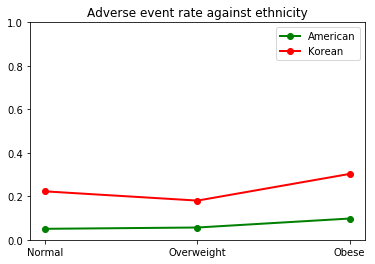

In [13]:
weightEthnicVSadverse = weightVSadverse[
    (weightVSadverse["Weight group"] == "Normal") |
    (weightVSadverse["Weight group"] == "Overweight") |
    (weightVSadverse["Weight group"] == "Obese")
]

x_pos = np.arange(3)
for i in ("American", "Korean"):
    subgroup = weightEthnicVSadverse[weightEthnicVSadverse["Ethnic"] == i]
    if subgroup.empty is False:
        subgroup = subgroup.set_index("Weight group").fillna(0)
        rate = subgroup["System adverse no."] / subgroup["Sample size"]
        plt.plot(x_pos, rate, "-o", lw=2, label = i, color=ethnicColor[i])

plt.xticks(x_pos, subgroup.index.values)
plt.legend()
plt.ylim(0,1)
plt.title("Adverse event rate against ethnicity")

plt.savefig(os.path.join(figurepath, "ethnicComparison.pdf"), bbox_inches="tight")
plt.show()

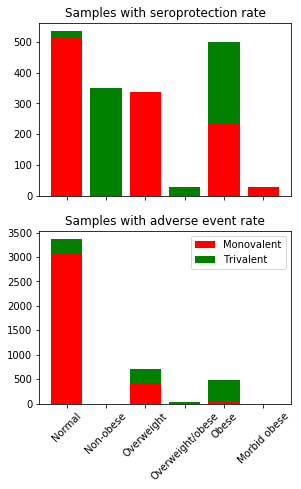

In [14]:
valentColor = {"Trivalent": "#008000", "Monovalent": "#FF0000"}

weightVSprotect = h1n1[["Vaccine type", "Weight group", "Sample size", "Seroprotection"]].dropna()
weightVSprotect["Seroprotection"] = weightVSprotect["Seroprotection"].astype(int)
weightVSprotect = weightVSprotect.groupby(["Vaccine type", "Weight group"])
weightVSprotect = weightVSprotect.agg({"Sample size": "sum", "Seroprotection": "sum"}).reset_index()

weightVSadverse = h1n1[["Vaccine type", "Weight group", "Sample size", "System adverse no."]].dropna()
weightVSadverse["System adverse no."] = weightVSadverse["System adverse no."].astype(int)
weightVSadverse = weightVSadverse.groupby(["Vaccine type", "Weight group"])
weightVSadverse = weightVSadverse.agg({"Sample size": "sum", "System adverse no.": "sum"}).reset_index()

fig, axes = plt.subplots(2, 1, sharex=True, figsize = (4.5, 7))
x_pos = np.arange(len(weightGroup))

bottom = np.zeros(len(weightGroup))
for i in weightVSprotect["Vaccine type"].unique():
    subgroup = weightVSprotect[weightVSprotect["Vaccine type"] == i]
    subgroup = subgroup.set_index("Weight group").fillna(0)
    axes[0].bar(
        x_pos,
        subgroup["Sample size"],
        label=i,
        color=valentColor[i],
        bottom=bottom
    )
    bottom += subgroup["Sample size"]
axes[0].set_title("Samples with seroprotection rate")

bottom = np.zeros(len(weightGroup))
axes[1].bar(x_pos, bottom)
for i in weightVSadverse["Vaccine type"].unique():
    subgroup = weightVSadverse[weightVSadverse["Vaccine type"] == i]
    subgroup = subgroup.set_index("Weight group").fillna(0)
    axes[1].bar(
        x_pos,
        subgroup["Sample size"],
        label=i,
        color=valentColor[i],
        bottom=bottom
    )
    bottom += subgroup["Sample size"]
axes[1].set_title("Samples with adverse event rate")

handles, labels = [], []
for ax in axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        if l not in labels:
            handles.append(h)
            labels.append(l)

plt.xticks(x_pos, weightGroup, rotation=45)
plt.legend(handles, labels, loc='upper right')
plt.savefig(os.path.join(figurepath, "valence.pdf"), bbox_inches="tight")
plt.show()

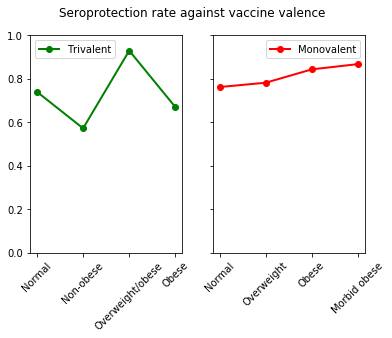

In [15]:
fig, axes = plt.subplots(1, 2, sharey=True)
fig.suptitle("Seroprotection rate against vaccine valence")

valence = "Trivalent"
weightValenceVSprotect = weightVSprotect[
    (weightVSprotect["Weight group"] == "Normal") |
    (weightVSprotect["Weight group"] == "Non-obese") |
    (weightVSprotect["Weight group"] == "Overweight/obese") |
    (weightVSprotect["Weight group"] == "Obese")
]

x_pos = np.arange(4)
subgroup = weightValenceVSprotect[weightValenceVSprotect["Vaccine type"] == valence]
subgroup = subgroup.set_index("Weight group").fillna(0)
rate = subgroup["Seroprotection"] / subgroup["Sample size"]
axes[0].plot(x_pos, rate, "-o", lw=2, label = valence, color=valentColor[valence])
        
plt.sca(axes[0])
plt.xticks(x_pos, subgroup.index.values, rotation=45)
plt.legend()

valence = "Monovalent"
weightValenceVSprotect = weightVSprotect[
    (weightVSprotect["Weight group"] == "Normal") |
    (weightVSprotect["Weight group"] == "Overweight") |
    (weightVSprotect["Weight group"] == "Obese") |
    (weightVSprotect["Weight group"] == "Morbid obese")
]

x_pos = np.arange(4)
subgroup = weightValenceVSprotect[weightValenceVSprotect["Vaccine type"] == valence]
subgroup = subgroup.set_index("Weight group").fillna(0)
rate = subgroup["Seroprotection"] / subgroup["Sample size"]
axes[1].plot(x_pos, rate, "-o", lw=2, label=valence, color=valentColor[valence])

plt.sca(axes[1])
plt.xticks(x_pos, subgroup.index.values, rotation=45)
plt.legend()
plt.ylim(0,1)

plt.savefig(os.path.join(figurepath, "valenceComparison.pdf"), bbox_inches="tight")
plt.show()

In [16]:
trivalent = df[df["Vaccine type"] == "Trivalent"]

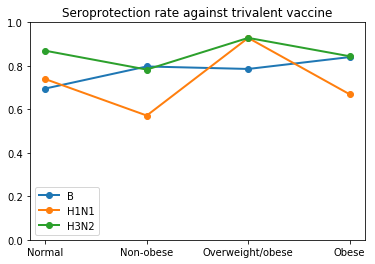

In [20]:
weightVSprotect = trivalent[["Weight group", "Vaccine strain", "Sample size", "Seroprotection"]].dropna()
weightVSprotect["Seroprotection"] = weightVSprotect["Seroprotection"].astype(int)
weightVSprotect = weightVSprotect.groupby(["Vaccine strain", "Weight group"])
weightVSprotect = weightVSprotect.agg({"Sample size": "sum", "Seroprotection": "sum"}).reset_index()
weightVSprotect = weightVSprotect.dropna()
weightVSprotect["Seroprotection rate"] = weightVSprotect["Seroprotection"] / weightVSprotect["Sample size"]

x_ticks = weightVSprotect["Weight group"].unique()
x_pos = np.arange(len(x_ticks))
for i in weightVSprotect["Vaccine strain"].unique():
    subgroup = weightVSprotect[weightVSprotect["Vaccine strain"] == i]
    subgroup = subgroup.set_index("Weight group").fillna(0)
    plt.plot(
        x_pos,
        subgroup["Seroprotection rate"],
        "-o",
        lw=2, 
        label=i
    )
plt.xticks(x_pos, x_ticks)
plt.ylim(0, 1)
plt.legend()
plt.title("Seroprotection rate against trivalent vaccine")
plt.savefig(os.path.join(figurepath, "trivalent.pdf"), bbox_inches="tight")
plt.show()

In [18]:
weightVSprotect = trivalent[["Subject", "Weight group", "Vaccine strain", "Sample size", "Seroprotection"]].dropna()
weightVSprotect = weightVSprotect[weightVSprotect["Vaccine strain"] == "B"]
weightVSprotect["Seroprotection"] = weightVSprotect["Seroprotection"].astype(int)
weightVSprotect = weightVSprotect.groupby(["Subject", "Weight group"])
weightVSprotect = weightVSprotect.agg({"Sample size": "sum", "Seroprotection": "sum"}).reset_index()
weightVSprotect = weightVSprotect.set_index("Weight group").fillna(0)
weightVSprotect = weightVSprotect[
    (weightVSprotect.index.values == "Normal") |
    (weightVSprotect.index.values == "Non-obese") |
    (weightVSprotect.index.values == "Overweight/obese") |
    (weightVSprotect.index.values == "Obese")    
]

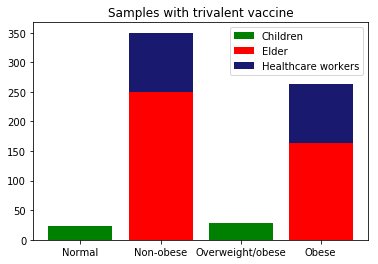

In [19]:
x_pos = np.arange(4)

bottom = np.zeros(4)
plt.bar(x_pos, bottom)
for i in weightVSprotect["Subject"].unique():
    subgroup = weightVSprotect[weightVSprotect["Subject"] == i]
    plt.bar(
        x_pos,
        subgroup["Sample size"],
        label=i,
        color=ageColor[i],
        bottom=bottom
    )
    bottom += subgroup["Sample size"]
    
plt.legend()
plt.xticks(x_pos, subgroup.index.values)
plt.title("Samples with trivalent vaccine")
plt.show()